# Módulo de extracción, transformación y carga de datos

<p align='center'>
  <img width='200' heigth='225' src='https://user-images.githubusercontent.com/62605744/171186764-43f7aae0-81a9-4b6e-b4ce-af963564eafb.png'>
</p>

- Universidad del Valle - Escuela de ingeniería de sistemas y computación
- Asignatura: Introducción a la ciencia de los datos
- Semestre 2024-II
- Profesor: Oswaldo Solarte Pabon

ETL en Python para base de datos de mensajería

#### Autores
- Diego Fernando Victoria - 202125877 - diego.victoria@correounivalle.edu.co
- Janiert Sebastián Salas - 201941265 - janiert.salas@correounivalle.edu.co

#### Creación y activación de un entorno en Python
```
python3 -m venv my_env
```
```
source my_env/bin/activate  
```

#### Instalación de librerías necesarias
```
pip install -r requirements.txt
```

#### Creación y configuración del archivo config.yml
```
echo mensajeriaOLTP: {drivername: postgresql, host: localhost, port: 5432, dbname: (Nombre de la bd), user: (Nombre del usuario propietario), password: (Contraseña del usuario propietario)} mensajeriaOLAP: {drivername: postgresql, host: localhost, port: 5432, dbname: (Nombre de la bd), user: (Nombre del usuario propietario), password: (Contraseña del usuario propietario)} > config.yml
```

#### Importación de librerías

In [264]:
from datetime import date
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError
import pandas as pd
import numpy as np
import holidays
import yaml
import locale
import matplotlib.pyplot as plt
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')

'es_ES.UTF-8'

#### Conexión con las bases de datos

In [265]:
# Cargar configuraciones
with open('config.yml', 'r') as f:
  config = yaml.safe_load(f)
  config_oltp = config['fuente']
  config_olap = config['bodega']

# Crear URLs de conexión
url_oltp = (f"{config_oltp['drivername']}://{config_oltp['user']}:{config_oltp['password']}@{config_oltp['host']}:"f"{config_oltp['port']}/{config_oltp['dbname']}")
url_olap = (f"{config_olap['drivername']}://{config_olap['user']}:{config_olap['password']}@{config_olap['host']}:"f"{config_olap['port']}/{config_olap['dbname']}")

# Crear las conexiones
oltp_conn, olap_conn = create_engine(url_oltp), create_engine(url_olap)

# Función para probar la conexión con las bases de datos
def comprobar_conexionBD(db_engine, db_name):
  try:
    with db_engine.connect() as connection:
      if connection.execute(text("SELECT 1")).fetchone() is not None:
        print(f"Conexión exitosa a base de datos {db_name}")
      else:
        print(f"No se pudo conectar a {db_name}")
  except SQLAlchemyError as e:
    print(f"Error al conectar a base de datos {db_name}: {e}")

comprobar_conexionBD(oltp_conn, config_oltp['dbname'])
comprobar_conexionBD(olap_conn, config_olap['dbname'])

Conexión exitosa a base de datos mensajeriaOLTP
Conexión exitosa a base de datos mensajeriaOLAP


## Dimensiones

### Dimensión cliente

#### Módulo de extracción

In [266]:
table_cliente = pd.read_sql_table('cliente', oltp_conn)
table_ciudad = pd.read_sql_table('ciudad', oltp_conn)
table_departamento = pd.read_sql_table('departamento', oltp_conn)
table_tipo_cliente = pd.read_sql_table('tipo_cliente', oltp_conn)

table_ciudad.head()

,ciudad_id,nombre,departamento_id
0,6,BUGA,1
1,5,BOGOTA,2
2,4,PASTO,4
3,3,POPAYAN,3
4,2,PALMIRA,1


#### Módulo de transformación

In [267]:
table_departamento = table_departamento.rename(columns={'nombre' : 'departamento'})
table_ciudad = (pd.merge(table_ciudad.rename(columns={'nombre' : 'ciudad'}), table_departamento, how='inner')
  .drop(columns=['departamento_id']))
table_tipo_cliente = (table_tipo_cliente.drop(columns=['descripcion']).rename(columns={'nombre': 'tipo_cliente'}))

dimension_cliente = pd.merge(table_cliente, table_ciudad, how='inner')
dimension_cliente = (pd.merge(dimension_cliente, table_tipo_cliente, how='inner')
  .drop(columns=['ciudad_id', 'tipo_cliente_id', 'coordinador_id', 'activo']))

dimension_cliente.set_index('cliente_id', inplace=True)

dimension_cliente.head()

,nit_cliente,nombre,email,direccion,telefono,nombre_contacto,sector,ciudad,departamento,tipo_cliente
cliente_id,,,,,,,,,,
1,25,Cliente 2,algo.com,Calle 100 No 25-18,327-00000,Cristiano Ronaldo,S,CALI,VALLE DEL CAUCA,Persona Juridica
2,123,Cliente 1,algo.com,Calle 100 No 25-18,327-00000,Cristiano Ronaldo,industrial,CALI,VALLE DEL CAUCA,Persona Juridica
6,24390-3,CLINICA DEPORTIVA DEL SUR,algo.com,Calle 100 No 25-18,327-00000,Cristiano Ronaldo,salud,CALI,VALLE DEL CAUCA,Persona Juridica
19,8301821,HOSPITAL ORTOPEDICO DE COLOMBIA,algo.com,Calle 100 No 25-18,327-00000,Cristiano Ronaldo,salud,CALI,VALLE DEL CAUCA,Persona Juridica
8,5017350-8,CLINICA NEFROLOGOS DE CALI,algo.com,Calle 100 No 25-18,327-00000,Cristiano Ronaldo,salud,CALI,VALLE DEL CAUCA,Persona Juridica


#### Módulo de carga

In [268]:
try:
  dimension_cliente.to_sql('dim_cliente', olap_conn, if_exists='replace')
except Exception as e:
  print(f"Error al cargar datos: {e}")

### Dimensión fecha

#### Módulo de extracción

In [269]:
table_estadosservicio = pd.read_sql_table('mensajeria_estadosservicio', oltp_conn, columns=['fecha', 'hora'])
table_novedadesservicio = pd.read_sql_table('mensajeria_novedadesservicio', oltp_conn, columns=['fecha_novedad'])
table_novedadesservicio['fecha_hora'] = pd.to_datetime(table_novedadesservicio['fecha_novedad'].dt.strftime('%Y-%m-%d %H:%M'))

table_novedadesservicio['fecha'] = table_novedadesservicio['fecha_novedad'].dt.date
table_novedadesservicio['hora'] = table_novedadesservicio['fecha_novedad'].dt.strftime('%H:%M') # intercambiar cambiar el formato
table_estadosservicio['hora'] = table_estadosservicio['hora'].astype(str).str[:5]
table_estadosservicio['fecha_hora'] = pd.to_datetime(table_estadosservicio['fecha'].astype(str) + ' ' + table_estadosservicio['hora'].astype(str))

#### Módulo de transformación

In [270]:
dimension_fecha = pd.concat([table_estadosservicio, table_novedadesservicio.drop(columns=['fecha_novedad'])])
dimension_fecha['fecha'] = pd.to_datetime(dimension_fecha['fecha'])

dimension_fecha["día"] = dimension_fecha["fecha"].dt.day
dimension_fecha["mes"] = dimension_fecha["fecha"].dt.month
dimension_fecha["año"] = dimension_fecha["fecha"].dt.year
dimension_fecha["día_semana"] = dimension_fecha["fecha"].dt.weekday
dimension_fecha["trimestre"] = dimension_fecha["fecha"].dt.quarter

dimension_fecha.head()

,fecha,hora,fecha_hora,día,mes,año,día_semana,trimestre
0,2024-01-29,01:13,2024-01-29 01:13:00,29,1,2024,0,1
1,2024-01-30,18:45,2024-01-30 18:45:00,30,1,2024,1,1
2,2024-02-06,11:34,2024-02-06 11:34:00,6,2,2024,1,1
3,2024-02-01,14:50,2024-02-01 14:50:00,1,2,2024,3,1
4,2024-04-06,16:11,2024-04-06 16:11:00,6,4,2024,5,2


In [271]:
dimension_fecha["día_del_año"] = dimension_fecha["fecha"].dt.day_of_year
dimension_fecha["nombre_mes"] = dimension_fecha["fecha"].dt.strftime('%B')
dimension_fecha["nombre_día"] = dimension_fecha["fecha"].dt.day_name()
dimension_fecha['nombre_día'] = dimension_fecha["nombre_día"].replace({'Monday': 'lunes', 'Tuesday': 'martes', 'Wednesday': 'miércoles', 'Thursday': 'jueves', 'Friday': 'viernes', 'Saturday': 'sábado', 'Sunday': 'domingo'})

dimension_fecha.head()

,fecha,hora,fecha_hora,día,mes,año,día_semana,trimestre,día_del_año,nombre_mes,nombre_día
0,2024-01-29,01:13,2024-01-29 01:13:00,29,1,2024,0,1,29,enero,lunes
1,2024-01-30,18:45,2024-01-30 18:45:00,30,1,2024,1,1,30,enero,martes
2,2024-02-06,11:34,2024-02-06 11:34:00,6,2,2024,1,1,37,febrero,martes
3,2024-02-01,14:50,2024-02-01 14:50:00,1,2,2024,3,1,32,febrero,jueves
4,2024-04-06,16:11,2024-04-06 16:11:00,6,4,2024,5,2,97,abril,sábado


In [272]:
co_holidays = holidays.CO(language="es")
dimension_fecha["es_festivo"] = dimension_fecha["fecha"].apply(lambda x:  x in co_holidays)
dimension_fecha["festivo"] = dimension_fecha["fecha"].apply(lambda x: co_holidays.get(x))
dimension_fecha["fin_de_semana"] = dimension_fecha["día_semana"].apply(lambda x: x>4)
dimension_fecha['fecha'] = dimension_fecha['fecha'].dt.date
dimension_fecha.head()

,fecha,hora,fecha_hora,día,mes,año,día_semana,trimestre,día_del_año,nombre_mes,nombre_día,es_festivo,festivo,fin_de_semana
0,2024-01-29,01:13,2024-01-29 01:13:00,29,1,2024,0,1,29,enero,lunes,False,None,False
1,2024-01-30,18:45,2024-01-30 18:45:00,30,1,2024,1,1,30,enero,martes,False,None,False
2,2024-02-06,11:34,2024-02-06 11:34:00,6,2,2024,1,1,37,febrero,martes,False,None,False
3,2024-02-01,14:50,2024-02-01 14:50:00,1,2,2024,3,1,32,febrero,jueves,False,None,False
4,2024-04-06,16:11,2024-04-06 16:11:00,6,4,2024,5,2,97,abril,sábado,False,None,True


In [273]:
dimension_fecha['fecha'] = pd.to_datetime(dimension_fecha['fecha']).dt.date
dimension_fecha['hora'] = pd.to_datetime(dimension_fecha['hora'].astype(str).str.split('.').str[0], format='%H:%M').dt.time

dimension_fecha.drop_duplicates(subset=['fecha', 'hora'], inplace=True)

dimension_fecha.reset_index(drop=True, inplace=True)
dimension_fecha['id'] = dimension_fecha.index
dimension_fecha.set_index('id', inplace=True)

#### Módulo de carga

In [274]:
try:
  dimension_fecha.to_sql('dim_fecha', olap_conn, if_exists='replace')
except Exception as e:
  print(f"Error al cargar datos: {e}")

### Dimensión mensajero

#### Módulo de extracción

In [275]:
tabla_mensajero = pd.read_sql_table('clientes_mensajeroaquitoy', oltp_conn)
tabla_user = pd.read_sql_table('auth_user', oltp_conn)
tabla_ciudad = pd.read_sql_table('ciudad', oltp_conn)
tabla_departamento = pd.read_sql_table('departamento', oltp_conn)

#### Módulo de transformación

In [276]:
dimension_mensajero = (tabla_mensajero[['id', 'user_id', 'activo', 'fecha_entrada', 'fecha_salida', 'salario', 'telefono', 'ciudad_operacion_id']]
  .rename(columns={'id' : 'id_mensajero'}))

tabla_ciudad = (pd.merge(tabla_ciudad.rename(columns={'nombre' : 'ciudad'}), tabla_departamento.rename(columns={'nombre' : 'departamento'}), how='inner')
  .drop(columns=['departamento_id'])) 

dimension_mensajero = (pd.merge(dimension_mensajero, tabla_ciudad, 
  how='left', left_on='ciudad_operacion_id', right_on='ciudad_id')
  .drop(columns=['ciudad_operacion_id', 'ciudad_id']))

tabla_user.drop(columns=['password', 'is_superuser', 'is_staff', 'date_joined', 'last_login'], inplace=True)

dimension_mensajero = (pd.merge(dimension_mensajero, tabla_user, 
  how='inner', left_on='user_id', right_on='id')
  .drop(columns=['user_id', 'id', 'activo', 'is_active', 'fecha_salida']))

dimension_mensajero['fecha_entrada'] = dimension_mensajero['fecha_entrada'].dt.date
dimension_mensajero.set_index('id_mensajero', inplace=True)
dimension_mensajero.sort_values(by=['id_mensajero']).head()

,fecha_entrada,salario,telefono,ciudad,departamento,username,first_name,last_name,email
id_mensajero,,,,,,,,,
1,NaT,NaN,310-300000,ACOPI YUMBO,VALLE DEL CAUCA,mensajero1,pepito_el_rapido,pepito_el_furioso,rapidos-furiosos@gmail.com
2,NaT,NaN,310-300000,NaN,NaN,mensajero2,pepito_el_rapido,pepito_el_furioso,rapidos-furiosos@gmail.com
3,2012-05-08,3000000.0,310-300000,CALI,VALLE DEL CAUCA,Biil-Gates,pepito_el_rapido,pepito_el_furioso,rapidos-furiosos@gmail.com
4,2018-12-17,1160000.0,310-300000,CALI,VALLE DEL CAUCA,Lionel_messi,pepito_el_rapido,pepito_el_furioso,rapidos-furiosos@gmail.com
5,2015-07-01,1160000.0,310-300000,NaN,NaN,James Rodriguez,pepito_el_rapido,pepito_el_furioso,rapidos-furiosos@gmail.com


#### Módulo de carga

In [277]:
try:
  dimension_mensajero.to_sql('dim_mensajero', olap_conn, if_exists='replace')
except Exception as e:
  print(f"Error al cargar datos: {e}")

### Dimensión sede

#### Módulo de extracción

In [278]:
table_sede = pd.read_sql_table('sede', oltp_conn)
table_ciudad = pd.read_sql_table('ciudad', oltp_conn)
table_departamento = pd.read_sql_table('departamento', oltp_conn)

#### Módulo de transformación

In [279]:
table_ciudad = (pd.merge(table_ciudad.rename(columns={'nombre' : 'ciudad'}), table_departamento.rename(columns={'nombre' : 'departamento'}), how='inner')
  .drop(columns=['departamento_id']))

dimension_sede = (pd.merge(table_sede.rename(columns={'nombre' : 'nombre_sede'}), table_ciudad, 
  how='inner', left_on='ciudad_id', right_on='ciudad_id')
  .drop(columns=['ciudad_id', 'cliente_id'])
  .sort_values(by='sede_id'))

dimension_sede.set_index('sede_id', inplace=True)

dimension_sede.head()

,nombre_sede,direccion,telefono,nombre_contacto,ciudad,departamento
sede_id,,,,,,
1,Sede principal - Cliente1,Los angeles distrito Latino,310-70000,JUAN PEREZ,CALI,VALLE DEL CAUCA
2,sede aux - cliente 1,Los angeles distrito Latino,310-70000,JUAN PEREZ,CALI,VALLE DEL CAUCA
3,TORRES DE MARACAIBO,Los angeles distrito Latino,310-70000,JUAN PEREZ,CALI,VALLE DEL CAUCA
4,INGENIO,Los angeles distrito Latino,310-70000,JUAN PEREZ,CALI,VALLE DEL CAUCA
5,VASQUEZ COBO,Los angeles distrito Latino,310-70000,JUAN PEREZ,CALI,VALLE DEL CAUCA


#### Módulo de carga

In [280]:
try:
  dimension_sede.to_sql('dim_sede', olap_conn, if_exists='replace')
except Exception as e:
  print(f"Error al cargar datos: {e}")

## Hechos

### Hecho novedades

#### Módulo de extracción

In [281]:
table_novedadesservicio = pd.read_sql_table('mensajeria_novedadesservicio', oltp_conn)
table_tipo_novedades = pd.read_sql_table('mensajeria_tiponovedad', oltp_conn)
dimension_fecha = pd.read_sql_table('dim_fecha', olap_conn)
dimension_mensajero = pd.read_sql_table('dim_mensajero', olap_conn)

#### Módulo de transformación

In [282]:
table_tipo_novedades.sort_values(by=['id'], inplace=True)
table_novedadesservicio['fecha_novedad'] = pd.to_datetime(table_novedadesservicio['fecha_novedad'].dt.strftime('%Y-%m-%d %H:%M'))

hecho_novedades = (pd.merge(
  table_novedadesservicio[['fecha_novedad', 'tipo_novedad_id']], 
  dimension_fecha[['fecha_hora', 'id', 'fecha']],
  how='left', left_on='fecha_novedad', right_on='fecha_hora')
  .drop(columns=['fecha_novedad', 'fecha_hora'])
  .rename(columns={'id': 'id_fecha'}))

conteo_novedades = {}

for tipo_id in table_tipo_novedades['id']: # genera todas las llaves con la dimensión fecha 
  conteo_novedades[f'num_novedades_{tipo_id}'] = (hecho_novedades[hecho_novedades['tipo_novedad_id'] == tipo_id]
    .groupby('fecha')['tipo_novedad_id']
    .count())

# conteo total por tipo novedad
conteo_novedades = pd.DataFrame(conteo_novedades).fillna(0).astype(int)
# num_novedades como la suma de los conteos por tipo
conteo_novedades['total_novedades'] = conteo_novedades.sum(axis=1)

hecho_novedades = (hecho_novedades.merge(conteo_novedades, on='fecha', how='left')
  .drop_duplicates(subset=['fecha'])
  .drop(columns=['fecha', 'tipo_novedad_id'])
  .reset_index(drop=True))

#hecho_novedades.head()
#print(hecho_novedades.shape[0])

#### Módulo de carga

In [283]:
try:
  hecho_novedades.to_sql('hecho_novedades', olap_conn, if_exists='replace', index_label='id')
except Exception as e:
  print(f"Error al cargar datos: {e}")

### Hecho servicios

#### Módulo de extracción

In [284]:
table_servicio = pd.read_sql_table('mensajeria_servicio', oltp_conn)
table_estadosservicio = pd.read_sql_table('mensajeria_estadosservicio', oltp_conn)
table_usuario = pd.read_sql_table('clientes_usuarioaquitoy', oltp_conn)
dimension_fecha = pd.read_sql('dim_fecha', olap_conn)

estados = [
  (1, 'id_fecha_iniciado'),
  (2, 'id_fecha_mensajero'),
  (3, 'id_fecha_recogida'),
  (4, 'id_fecha_entrega'),
  (5, 'id_fecha_terminado')]

#### Módulo de transformación

In [285]:
hecho_servicios = (table_servicio[['id', 'mensajero_id', 'mensajero2_id', 'mensajero3_id', 'usuario_id']]
  .rename(columns={'mensajero_id' : 'mensajero1_id'})
  .astype('Int32')
  .replace({pd.NA: None}))
hecho_servicios = (pd.merge(hecho_servicios, table_usuario[['id', 'cliente_id', 'sede_id']].rename(columns={'id' : 'usuario_id'}), 
  how='left', on='usuario_id'))

In [286]:
# selecciona el último mensajero que prestó el servicio
hecho_servicios['mensajero_id'] = (hecho_servicios[['mensajero3_id', 'mensajero2_id', 'mensajero1_id']]
  .astype('Int32')
  .replace({pd.NA: None})
  .bfill(axis=1)
  .infer_objects(copy=False)
  .iloc[:, 0])

hecho_servicios.drop(columns=['mensajero3_id', 'mensajero2_id', 'mensajero1_id'], inplace=True)

In [287]:
dimension_fecha['hora'] = dimension_fecha['hora'].astype(str).str[:5]

for estado_id, nombre in estados: # genera todas las llaves con la dimensión fecha 
  filtered_estados = (table_estadosservicio[['estado_id', 'servicio_id', 'fecha', 'hora']]
    .query(f"estado_id == {estado_id}")
    .drop(columns=['estado_id'])
    .drop_duplicates(subset=['servicio_id']))
  
  filtered_estados['hora'] = filtered_estados['hora'].astype(str).str[:5]

  filtered_estados = (pd.merge(filtered_estados, dimension_fecha[['fecha', 'hora', 'id']],
    how='left', 
    on=['fecha', 'hora'])
    .rename(columns={'id': nombre})
    .drop(columns=['fecha', 'hora']))

  hecho_servicios = (hecho_servicios
    .merge(filtered_estados, how='left', left_on='id', right_on='servicio_id')
    .drop(columns=['servicio_id'])
    .astype('Int32')
    .replace({pd.NA: None}))

for i in range(len(estados) - 1):
  estado_actual = estados[i][1]
  estado_siguiente = estados[i + 1][1]
    
  tiempos_estados = hecho_servicios[['id', estado_actual, estado_siguiente]].rename(columns={'id': 'id_servicio'})
    
  tiempos_estados = (pd.merge(tiempos_estados, dimension_fecha[['id', 'fecha_hora']], 
    how='left', left_on=estado_actual, right_on='id')
    .rename(columns={'fecha_hora': estado_actual.replace("id_", "")})
    .drop(columns=['id', estado_actual]))

  tiempos_estados = (pd.merge(tiempos_estados, dimension_fecha[['id', 'fecha_hora']], 
    how='left', left_on=estado_siguiente, right_on='id')
    .rename(columns={'fecha_hora': estado_siguiente.replace("id_", "")})
    .drop(columns=['id', estado_siguiente]))

  # diferencia de tiempo entre los pares de estados
  tiempos_estados['diferencia_tiempo'] = tiempos_estados[estado_siguiente.replace("id_", "")] - tiempos_estados[estado_actual.replace("id_", "")]

  # diferencia en horas y minutos
  tiempos_estados[f'horas{estado_actual.replace("id_fecha", "")}_{estado_siguiente.replace("id_fecha_", "")}'] = ((tiempos_estados['diferencia_tiempo'].dt.total_seconds() / 3600)
    .round()
    .astype('Int32')
    .replace({pd.NA: None}))
    
  tiempos_estados.drop(columns=[estado_actual.replace("id_", ""), estado_siguiente.replace("id_", ""), 'diferencia_tiempo'])

  hecho_servicios = (pd.merge(hecho_servicios, tiempos_estados.drop(columns=[estado_actual.replace("id_", ""), estado_siguiente.replace("id_", ""), 'diferencia_tiempo']),
    how='left', left_on='id', right_on='id_servicio')
    .drop(columns=['id_servicio']))

tiempos_estados = hecho_servicios[['id', estados[0][1], estados[len(estados) - 1][1]]]

tiempos_estados = (pd.merge(tiempos_estados.rename(columns={'id' : 'id_servicio'}), dimension_fecha[['id', 'fecha_hora']], 
  how='inner', left_on=estados[0][1], right_on='id')
  .drop(columns=['id_fecha_iniciado', 'id'])
  .rename(columns={'fecha_hora' : 'fecha_hora_iniciado'}))

tiempos_estados = (pd.merge(tiempos_estados, dimension_fecha[['id', 'fecha_hora']], 
  how='inner', left_on='id_fecha_terminado', right_on='id')
  .drop(columns=['id_fecha_terminado', 'id'])
  .rename(columns={'fecha_hora' : 'fecha_hora_terminado'}))

tiempos_estados['horas_iniciado_terminado'] = (
  ((tiempos_estados['fecha_hora_terminado'] - tiempos_estados['fecha_hora_iniciado']).dt.total_seconds() / 3600)
  .round()
  .astype('Int32'))

hecho_servicios = (pd.merge(hecho_servicios, tiempos_estados.drop(columns=['fecha_hora_iniciado', 'fecha_hora_terminado']), 
  how='left', left_on='id', right_on='id_servicio')
  .drop(columns=['id_servicio'])
  .replace({pd.NA: None}))

#print(hecho_servicios.shape[0])
#hecho_servicios.sort_values(by=['id']).head()

#### Módulo de carga

In [288]:
try:
  hecho_servicios.set_index('id').to_sql('hecho_servicios', olap_conn, if_exists='replace')
except Exception as e:
  print(f"Error al cargar datos: {e}")

## Solución preguntas

### Pregunta 1
¿En qué meses del año los clientes solicitan más servicios de mensajería?

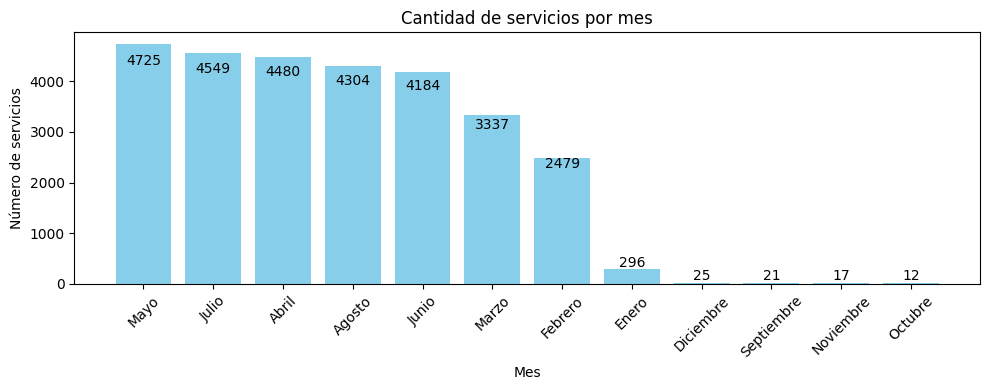

El mes con más servicios reportados es Mayo con 4725 servicios.


In [289]:
# Mes con más servicios en general (todos los años)
hecho_servicios_preguntas = hecho_servicios[['id', 'id_fecha_iniciado']].rename(columns={'id' : 'id_servicio'})

hecho_servicios_preguntas = (pd.merge(hecho_servicios_preguntas, dimension_fecha[['id', 'año','mes']].astype('Int32'), 
  how='left', left_on='id_fecha_iniciado', right_on='id').drop(columns=['id', 'id_fecha_iniciado'])) 

hecho_servicios_preguntas = (hecho_servicios_preguntas.groupby('mes')['id_servicio']
  .count()
  .reset_index()
  .rename(columns={'id_servicio': 'num_servicios'}))

hecho_servicios_preguntas['mes'] = hecho_servicios_preguntas['mes'].map({ 1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre' })

hecho_servicios_preguntas.sort_values(by=['num_servicios'], ascending=False, inplace=True)

plt.figure(figsize=(10, 4))
bars = plt.bar(hecho_servicios_preguntas['mes'], hecho_servicios_preguntas['num_servicios'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Número de servicios')
plt.title('Cantidad de servicios por mes')
plt.xticks(rotation=45)
plt.tight_layout()

# Agregar etiquetas con la cantidad de servicios en cada barra
for bar in bars:
  height = bar.get_height()
  plt.text(
    bar.get_x() + bar.get_width() / 2,
    height - (height * 0.1),
    f'{int(height)}',
    ha='center', va='bottom', color='black', fontsize=10)

plt.show()

mes_con_mas_servicios = hecho_servicios_preguntas.iloc[0]
print(f"El mes con más servicios reportados es {mes_con_mas_servicios['mes']} con {mes_con_mas_servicios['num_servicios']} servicios.")

### Pregunta 2
¿Cuáles son los días donde más solicitudes hay?

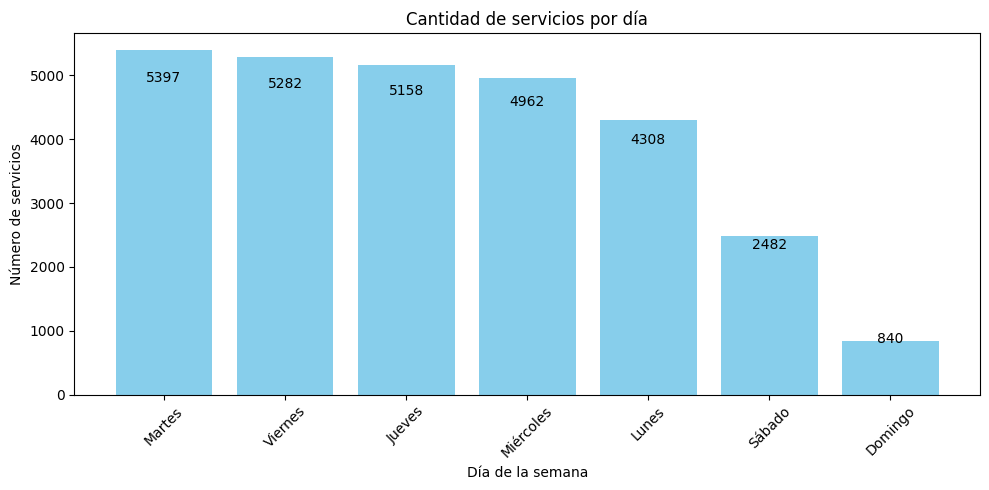

El día con más servicios reportados es Martes con 5397 servicios.


In [290]:
# Servicios por día de la semana global (todos los años)
hecho_servicios_preguntas = hecho_servicios[['id', 'id_fecha_iniciado']].rename(columns={'id' : 'id_servicio'})

hecho_servicios_preguntas = (pd.merge(hecho_servicios_preguntas, dimension_fecha[['id','día_semana']].astype(int), 
  how='left', left_on='id_fecha_iniciado', right_on='id')
  .drop(columns=['id', 'id_fecha_iniciado']))

# Agrupa por 'día_semana' y cuenta la cantidad de servicios
hecho_servicios_preguntas = (hecho_servicios_preguntas
  .groupby('día_semana')['id_servicio']
  .count()
  .reset_index()
  .rename(columns={'id_servicio': 'num_servicios'}))

hecho_servicios_preguntas['día_semana'] = (hecho_servicios_preguntas['día_semana']
  .replace({0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}))

hecho_servicios_preguntas.sort_values(by=['num_servicios'], ascending=False, inplace=True)

plt.figure(figsize=(10, 5))
bars = plt.bar(hecho_servicios_preguntas['día_semana'], hecho_servicios_preguntas['num_servicios'], color='skyblue')
plt.xlabel('Día de la semana')
plt.ylabel('Número de servicios')
plt.title('Cantidad de servicios por día')
plt.xticks(rotation=45)
plt.tight_layout()

# Agregar etiquetas con la cantidad de servicios en cada barra
for bar in bars:
  height = bar.get_height()
  plt.text(
    bar.get_x() + bar.get_width() / 2,
    height - (height * 0.1),
    f'{int(height)}',
    ha='center', va='bottom', color='black', fontsize=10)

plt.show()

dia_con_mas_servicios = hecho_servicios_preguntas.iloc[0]
print(f"El día con más servicios reportados es {dia_con_mas_servicios['día_semana']} con {dia_con_mas_servicios['num_servicios']} servicios.")

### Pregunta 3
¿A qué hora los mensajeros están más ocupados?

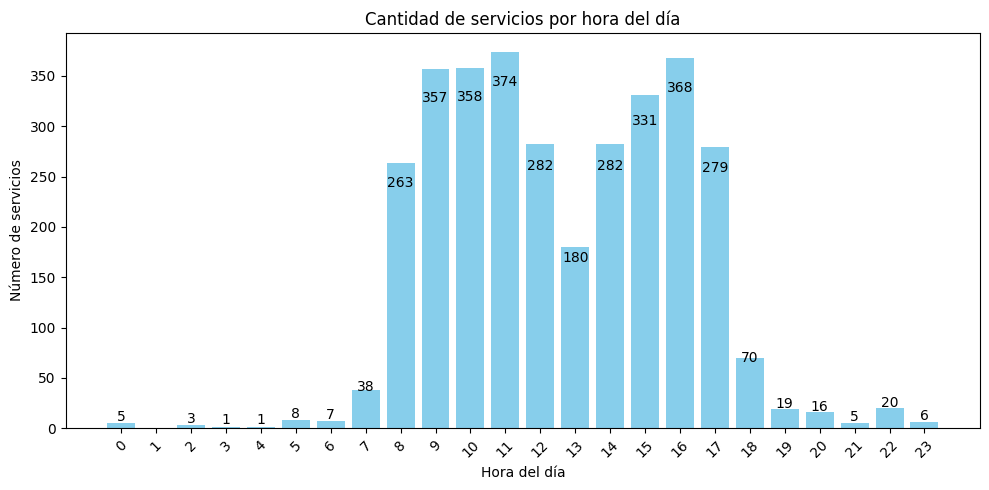

La hora con más servicios reportados es/son 11 del día con 374 servicios.


In [291]:
# Hora en que los mensajeros están más ocupados (se asume la hora de más ocupado como la hora de recogida) global
hecho_servicios_preguntas = hecho_servicios[['id', 'id_fecha_recogida']].rename(columns={'id' : 'id_servicio'})

hecho_servicios_preguntas = (pd.merge(hecho_servicios_preguntas, dimension_fecha[['id', 'hora']], 
  how='inner', left_on='id_fecha_recogida', right_on='id')
  .drop(columns=['id', 'id_fecha_recogida']))

hecho_servicios_preguntas['hora'] = pd.to_datetime(hecho_servicios_preguntas['hora'], format='%H:%M').dt.hour

hecho_servicios_preguntas = (hecho_servicios_preguntas.groupby('hora')['id_servicio']
  .count()
  .reset_index()
  .rename(columns={'id_servicio': 'num_servicios'}))

hecho_servicios_preguntas.sort_values(by='num_servicios', ascending=False, inplace=True)

plt.figure(figsize=(10, 5))
bars = plt.bar(hecho_servicios_preguntas['hora'], hecho_servicios_preguntas['num_servicios'], color='skyblue')
plt.xlabel('Hora del día')
plt.ylabel('Número de servicios')
plt.title('Cantidad de servicios por hora del día')
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 24, 1)) # Mostrar todas las horas del día en el eje x
plt.tight_layout()

# Agregar etiquetas con la cantidad de servicios en cada barra
for bar in bars:
  height = bar.get_height()
  plt.text(
    bar.get_x() + bar.get_width() / 2,
    height - (height * 0.1),
    f'{int(height)}',
    ha='center', va='bottom', color='black', fontsize=10)

plt.show()

dia_con_mas_servicios = hecho_servicios_preguntas.iloc[0]
print(f"La hora con más servicios reportados es/son {dia_con_mas_servicios['hora']} del día con {dia_con_mas_servicios['num_servicios']} servicios.")

### Pregunta 4
Número de servicios solicitados por cliente y por mes?

Servicios solicitados por cliente:


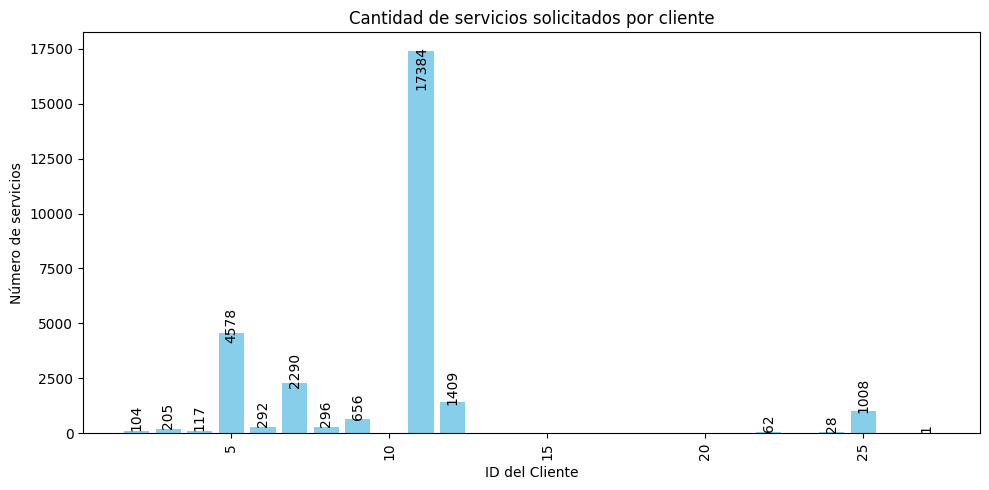

El cliente con más servicios reportados es el 11 con 17384 servicios.

Servicios solicitados por mes por cliente:


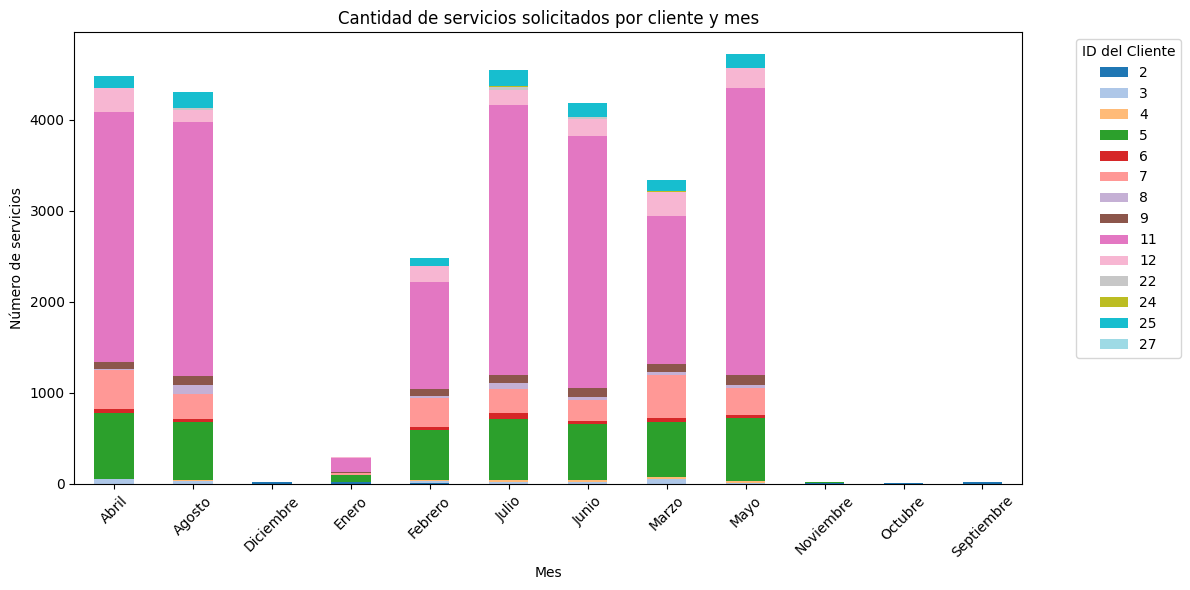

In [292]:
# cantidad de servicios solicitados por cliente
hecho_servicios_preguntas = (hecho_servicios.groupby('cliente_id')['id']
  .count()
  .reset_index()
  .rename(columns={'id': 'num_servicios'}))

hecho_servicios_preguntas.sort_values(by='num_servicios', ascending=False, inplace=True)

#print(conteo_servicios_por_cliente.shape[0])
#print("Servicios solicitados por cliente:")
#print(hecho_servicios_preguntas)
print("Servicios solicitados por cliente:")

# Crear la gráfica
plt.figure(figsize=(10, 5))
bars = plt.bar(hecho_servicios_preguntas['cliente_id'], hecho_servicios_preguntas['num_servicios'], color='skyblue')
plt.xlabel('ID del Cliente')
plt.ylabel('Número de servicios')
plt.title('Cantidad de servicios solicitados por cliente')
plt.xticks(rotation=90)
plt.tight_layout()

# Agregar etiquetas con la cantidad de servicios en cada barra
for bar in bars:
  height = bar.get_height()
  plt.text(
    bar.get_x() + bar.get_width() / 2,
    height - (height * 0.1),
    f'{int(height)}',
    ha='center', va='bottom', color='black', fontsize=10, rotation=90)

# Mostrar la gráfica
plt.show()

cliente_con_mas_servicios = hecho_servicios_preguntas.iloc[0]
print(f"El cliente con más servicios reportados es el {cliente_con_mas_servicios['cliente_id']} con {cliente_con_mas_servicios['num_servicios']} servicios.")

# Mes con más servicios en general (todos los años)
# Agregar mes y cliente al análisis
hecho_servicios_preguntas = hecho_servicios[['id', 'cliente_id', 'id_fecha_iniciado']].rename(columns={'id': 'id_servicio'})

# Unir con la dimensión fecha para obtener el mes
hecho_servicios_preguntas = pd.merge(
    hecho_servicios_preguntas,
    dimension_fecha[['id', 'mes']].astype('Int32'),
    how='left',
    left_on='id_fecha_iniciado',
    right_on='id'
).drop(columns=['id', 'id_fecha_iniciado'])

# Agrupar por mes y cliente
hecho_servicios_agrupados = hecho_servicios_preguntas.groupby(['mes', 'cliente_id'])['id_servicio'] \
    .count() \
    .reset_index() \
    .rename(columns={'id_servicio': 'num_servicios'})

# Mapeo del número del mes a su nombre
hecho_servicios_agrupados['mes'] = hecho_servicios_agrupados['mes'].map({
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio',
    7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
})

# Crear una tabla pivote para la visualización
pivot_data = hecho_servicios_agrupados.pivot(index='mes', columns='cliente_id', values='num_servicios').fillna(0)

# Gráfica de barras apiladas
pivot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='tab20'
)
plt.title('Cantidad de servicios solicitados por cliente y mes')
plt.xlabel('Mes')
plt.ylabel('Número de servicios')
plt.legend(title='ID del Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar la gráfica
print("\nServicios solicitados por mes por cliente:")
plt.show()

### Pregunta 5
Mensajeros más eficientes (Los que más servicios prestan)

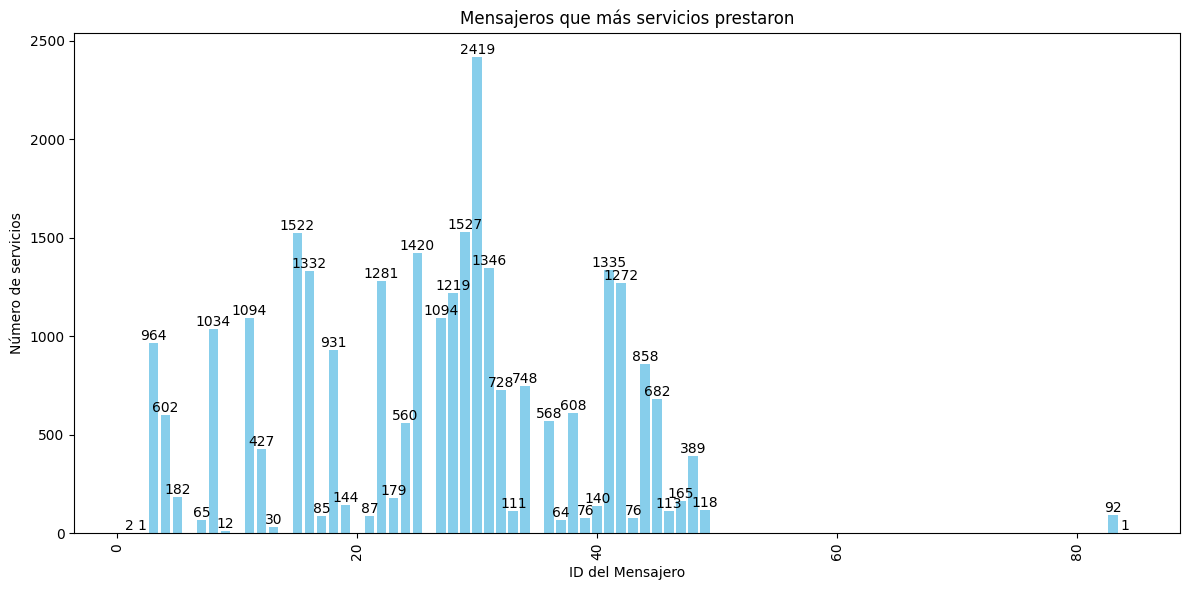

El mensajero que más servicios prestó es el 30 con 2419 servicios.


In [293]:
# mensajero que más servicios prestó de forma global

# Cuenta las apariciones de cada mensajero
hecho_servicios_preguntas = hecho_servicios['mensajero_id'].value_counts().reset_index()
hecho_servicios_preguntas.columns = ['mensajero_id', 'numero_servicios']

hecho_servicios_preguntas = hecho_servicios_preguntas.astype('Int32').sort_values(by='numero_servicios', ascending=False)

# Crear la gráfica
plt.figure(figsize=(12, 6))
bars = plt.bar(hecho_servicios_preguntas['mensajero_id'], hecho_servicios_preguntas['numero_servicios'], color='skyblue')
plt.xlabel('ID del Mensajero')
plt.ylabel('Número de servicios')
plt.title('Mensajeros que más servicios prestaron')
plt.xticks(rotation=90)
plt.tight_layout()

# Agregar etiquetas con la cantidad de servicios en cada barra
for bar in bars:
  height = bar.get_height()
  plt.text(
    bar.get_x() + bar.get_width() / 2,
    height,
    f'{int(height)}',
    ha='center', va='bottom', color='black', fontsize=10
  )

# Mostrar la gráfica
plt.show()

mensajero_con_mas_servicios = hecho_servicios_preguntas.iloc[0]
print(f"El mensajero que más servicios prestó es el {mensajero_con_mas_servicios['mensajero_id']} con {mensajero_con_mas_servicios['numero_servicios']} servicios.")

### Pregunta 6
¿Cuáles son las sedes que más servicios solicitan por cada cliente?

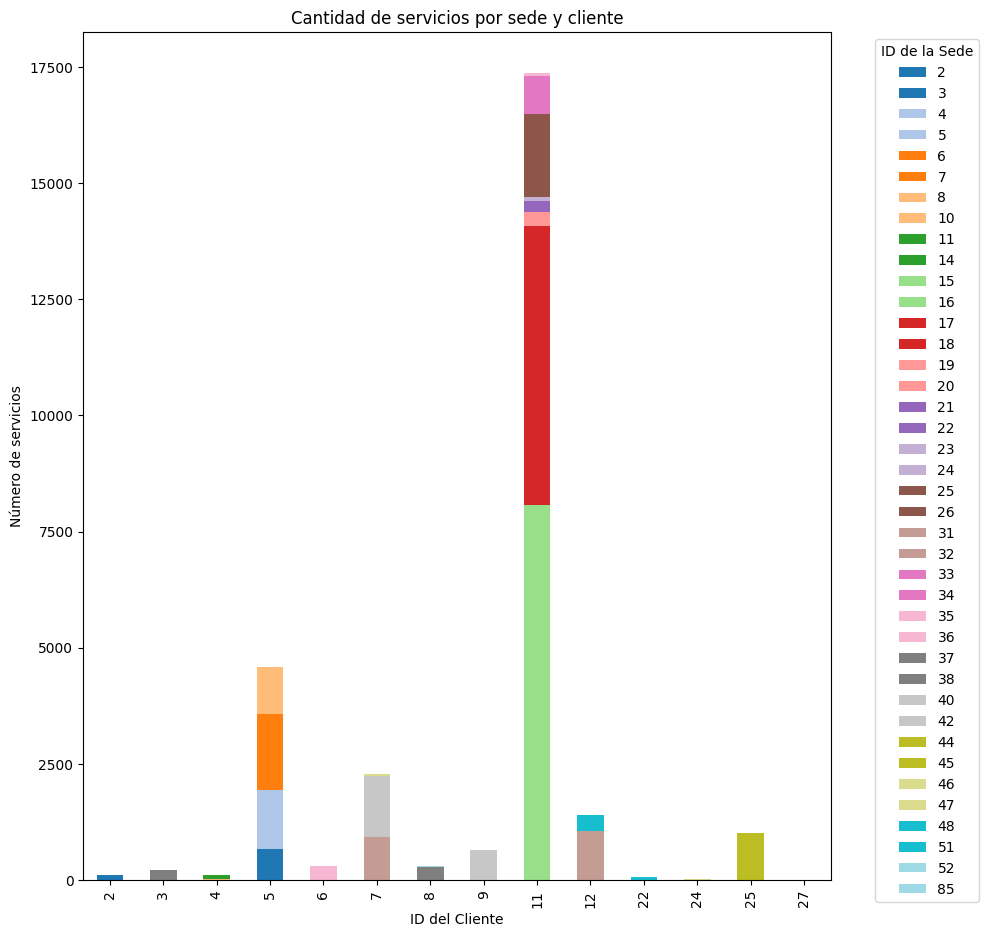

In [294]:
# número de servicios por cada sede de cada cliente
hecho_servicios_preguntas = (hecho_servicios.groupby(['usuario_id', 'cliente_id', 'sede_id'])['id']
  .count()
  .reset_index()
  .rename(columns={'id': 'num_servicios'})
  # Ordena primero por 'cliente_id' ascendente, luego por 'num_servicios' descendente
  .sort_values(by=['cliente_id', 'num_servicios'], ascending=[True, False]))

#print(hecho_servicios_preguntas.drop(columns=['usuario_id']))

# Agrupar por cliente y sede
hecho_servicios_agrupados = hecho_servicios.groupby(['cliente_id', 'sede_id'])['id'] \
  .count() \
  .reset_index() \
  .rename(columns={'id': 'num_servicios'})

# Crear una tabla pivote para la visualización
pivot_data = hecho_servicios_agrupados.pivot(index='cliente_id', columns='sede_id', values='num_servicios').fillna(0)

# Crear la gráfica
pivot_data.plot(
  kind='bar',
  stacked=True,
  figsize=(10, 10),
  colormap='tab20'
)
plt.title('Cantidad de servicios por sede y cliente')
plt.xlabel('ID del Cliente')
plt.ylabel('Número de servicios')
plt.legend(title='ID de la Sede', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

### Pregunta 7
¿Cuál es el tiempo promedio de entrega desde que se solicita el servicio hasta que se cierra el caso?

In [295]:
print("El tiempo promedio desde que se inicia un servicio hasta que se completa es de", round(hecho_servicios['horas_iniciado_terminado'].mean(), 2), "horas")

El tiempo promedio desde que se inicia un servicio hasta que se completa es de 5.83 horas


### Pregunta 8
Mostrar los tiempos de espera por cada fase del servicio: Iniciado, Con mensajero asignado, recogido en origen, Entregado en Destino, Cerrado. En que fase del servicio hay más demoras?

Horas promedios de cada columna:
horas_iniciado_mensajero    2.429939
horas_mensajero_recogida    2.432250
horas_recogida_entrega      1.918259
horas_entrega_terminado     1.751475
dtype: float64
La columna con mayor promedio de demora es 'horas_mensajero_recogida' con un promedio de 2.43 horas.


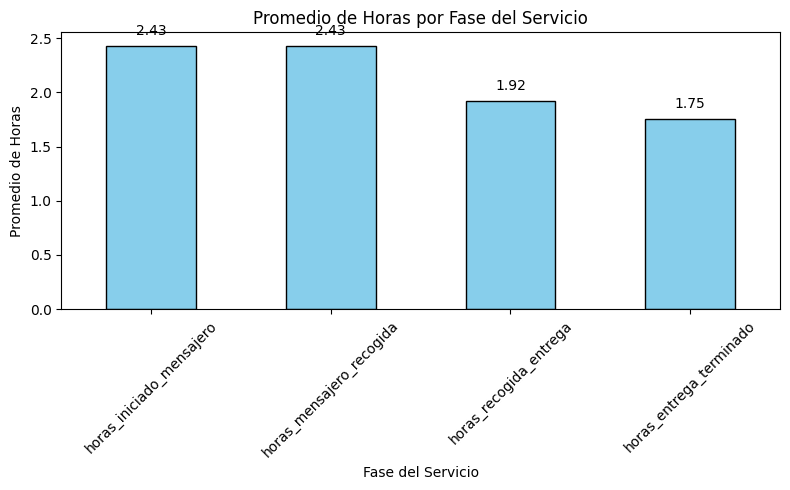

In [296]:
hecho_servicios_preguntas = hecho_servicios

# Configuración para ignorar valores faltantes en el cálculo de promedios
hecho_servicios_preguntas[['horas_iniciado_mensajero', 'horas_mensajero_recogida', 'horas_recogida_entrega', 'horas_entrega_terminado']] = (
    hecho_servicios_preguntas[['horas_iniciado_mensajero', 'horas_mensajero_recogida', 'horas_recogida_entrega', 'horas_entrega_terminado']]
    .replace({None: np.nan})  # Sustituir valores None por NaN
    .infer_objects(copy=False)
    .where(lambda x: x >= 0, np.nan)  # Reemplazar valores negativos con NaN
)

promedios = hecho_servicios_preguntas[['horas_iniciado_mensajero', 'horas_mensajero_recogida', 'horas_recogida_entrega', 'horas_entrega_terminado']].mean()

print(f"Horas promedios de cada columna:\n{promedios}")
print(f"La columna con mayor promedio de demora es '{promedios.idxmax()}' con un promedio de {promedios.max():.2f} horas.")

plt.figure(figsize=(8, 5))
promedios.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Promedio de Horas por Fase del Servicio')
plt.xlabel('Fase del Servicio')
plt.ylabel('Promedio de Horas')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar los valores sobre las barras
for index, value in enumerate(promedios):
    plt.text(index, value + 0.1, f'{value:.2f}', ha='center', fontsize=10)

plt.show()


### Pregunta 9
¿Cuáles son las novedades que más se presentan durante la prestación del servicio?

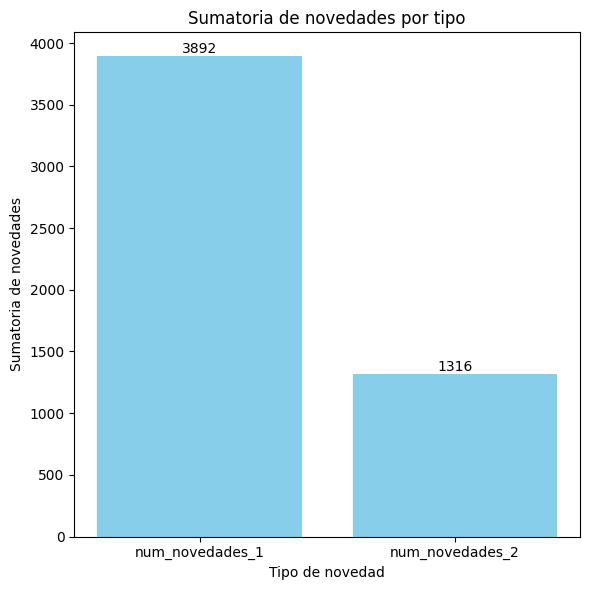

In [297]:
sumatorias = hecho_novedades[['num_novedades_1', 'num_novedades_2']].sum()

plt.figure(figsize=(6, 6))
bars = plt.bar(sumatorias.index, sumatorias.values, color='skyblue')

for bar in bars:
  height = bar.get_height()
  plt.text(
    bar.get_x() + bar.get_width() / 2,
    height,
    f'{int(height)}',  # Etiqueta con el valor entero
    ha='center', va='bottom', fontsize=10, color='black'
  )

plt.xlabel('Tipo de novedad')
plt.ylabel('Sumatoria de novedades')
plt.title('Sumatoria de novedades por tipo')
plt.tight_layout()

plt.show()

# novedad1 -> Novedades del servicio
# noveadd2 -> No pudo continuar